# Flower category recognition using Convolutional Neural Networks + Transfer Learning 


In [ ]:
!pip install config
!pip install tflearn

     |████████████████████████████████| 112kB 16.7MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp36-none-any.whl size=127301 sha256=fb44a092ccba50ac136f6a065052ece41978ee70e8256bded82f6a885e75fa42
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [ ]:
#Loading Libraries

#Utilities (Reading data, manipulating files, plotting...)
import os
import glob
import imageio
import tarfile
import numpy as np
import pandas as pd
from scipy.io import loadmat
from shutil import copyfile, rmtree
import sys
import config
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.misc
from keras.utils import to_categorical
from keras.engine import Model
#Keras & its utilities
from keras import backend as K
import tensorflow as tf
import keras
from keras import layers, regularizers, models, Input
import tflearn as tfl
from keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D, ZeroPadding2D, merge
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from scipy.io import loadmat
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report
#Loading the VGG16 model
#from keras.applications import VGG16
from keras.applications import DenseNet121


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1 - Loading and Subsetting the DataSet 
First, we start by downloading and extracting the data set files : 
- "102flowers.tgz" : Flower Pictures (.jpg format with a name of the form image_00001 -> image_08189 )
- "imagelabels.mat" : Flower Labels (From 1-102)
- "setid.mat" : Flower Ids for data splitting (Train, Validation, Test) 
- "names.csv" : Flowers names ordered by their labels (starting from 1)  
We put the whole in a single folder, say "flower102".


In [ ]:
#Setting Data Paths
root_dir = "/content/drive/MyDrive/"
data_path = root_dir + 'Flowers102'      #You must replace it with your path to the directory of the dataset
flowers_archive_path = os.path.join(data_path, 'jpg')
image_labels_path = os.path.join(data_path, 'imagelabels.mat')
setid_path = os.path.join(data_path, 'setid.mat')
names_path = os.path.join(data_path, 'flowers_names.csv')

In [ ]:
#Reading data splitting
setid = loadmat(os.path.join(data_path,"setid.mat"))
idx_train = setid['trnid'][0] - 1   # -1 to have Zero-based indexes
idx_test = setid['tstid'][0] - 1
idx_valid = setid['valid'][0] - 1

In [ ]:
#Reading labels
image_labels = loadmat(image_labels_path)['labels'][0] - 1
#Reading names (a set of flowers label-name mapping)
image_names=pd.read_csv(names_path, sep=',', names=('labels','name'), header=0)

In [ ]:
print('Image labels : \n'+ str(image_labels))
print('Labels-Names mapping DataSet \n'+str(image_names.head()))

Image labels : 
[76 76 76 ... 61 61 61]
Labels-Names mapping DataSet 
   labels                       name
0       0              pink primrose
1       1  hard-leaved pocket orchid
2       2           canterbury bells
3       3                  sweet pea
4       4           english marigold


In [ ]:
#Getting all the image files names (contained in the base directory)
files = sorted(glob.glob(os.path.join(data_path, 'jpg', '*.jpg')))
all_labels = np.array([i for i in zip(files, image_labels)])

In [ ]:
#Utility function for moving images to labeled-folders (train, valid, test)
def move_files(dir_name, labels):
    cur_dir_path = os.path.join(data_path, dir_name)
    if not os.path.exists(cur_dir_path):
        os.mkdir(cur_dir_path)

    for i in range(0, 102):
        class_dir = os.path.join(data_path, dir_name, str(i))
        os.mkdir(class_dir)

    for label in labels:
        src = str(label[0])
        dst = os.path.join(data_path, dir_name, label[1], src.split(os.sep)[-1])
        copyfile(src, dst)

In [ ]:
#Gathering labeled folders together within each split
if 'train' not in os.listdir(data_path):
    move_files('train', all_labels[idx_test, :])
if 'test' not in os.listdir(data_path):
    move_files('test', all_labels[idx_train, :])
if 'valid' not in os.listdir(data_path):
    move_files('valid', all_labels[idx_valid, :])

In [ ]:
#total training images per category (some categories)
for cat in range(102):
    if (cat//10 == 0):
        print('total training category ' +str(cat)+' images:', len(os.listdir(os.path.join(data_path, "train",str(cat)))))

total training category 0 images: 20
total training category 1 images: 40
total training category 2 images: 20
total training category 3 images: 36
total training category 4 images: 45
total training category 5 images: 25
total training category 6 images: 20
total training category 7 images: 65
total training category 8 images: 26
total training category 9 images: 25


Having all the data labeled and splitted in the appropriate folders, it's time to read it and preprocess it. Fortunately, keras has some build-in functions that take care of these steps, particularly the **ImageDataGenerator** function that helps quickly setting up Python generators that can automatically turn image files on disk into batches of preprocessed tensors, which avoids loading of the whole data in memory.  

In [ ]:
#Setting data generators for train, validation and test sets
train_dataGen = ImageDataGenerator(rescale=1./255,  preprocessing_function=preprocess_input)
train_generator = train_dataGen.flow_from_directory(directory = os.path.join(data_path, "train"), target_size=(227,227), batch_size=8, color_mode='rgb',class_mode="categorical", shuffle=True)

validation_dataGen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
validation_generator = train_dataGen.flow_from_directory(directory = os.path.join(data_path, "valid"), target_size=(227,227), batch_size=8, color_mode='rgb',class_mode="categorical")

test_dataGen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
test_generator = train_dataGen.flow_from_directory(directory = os.path.join(data_path, "test"), target_size=(227,227), batch_size=16, color_mode='rgb',class_mode="categorical")

Found 6149 images belonging to 102 classes.
Found 1020 images belonging to 102 classes.
Found 1020 images belonging to 102 classes.


In [ ]:
#Batch training parameters
m_train = len(train_generator.classes)
batch_tr = train_generator.batch_size

In [ ]:
train_generator.class_indices['2']

14

If we take a look at the 'train_generator.class_indices' dictionary, we will see that image labels used to identify flowers by the previously created directories don't match the class labels actually used by the generators. Thus, to obtain the names of the flowers, we have to create an intermediate mapping between the folders labels and the class labels used by the generator.

In [ ]:
class_label_map = pd.DataFrame.from_dict(train_generator.class_indices, orient='index', columns=['Class'])
class_label_map['Label'] = np.array(class_label_map.index, dtype='int32')
class_label_map.reset_index(inplace=True, drop=True)
class_label_map.head()

,Class,Label
0,0,0
1,1,1
2,2,10
3,3,100
4,4,101


In [ ]:
#Function that maps the images labels (1-102) to the flowers names 
def getName(one_hot_label, image_names = image_names, class_indices = class_label_map):
    index = np.argmax(one_hot_label)
    label = class_indices.iloc[index].Label
    return(image_names.loc[label,'name'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images shape (batch) :  (8, 227, 227, 3)
labels shape (batch) :  (8, 102)
Let's look at an example from the first batch 

image class label : 12
image original label : 18
flower name  : balloon flower


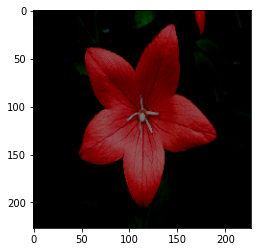

In [ ]:
for imgs, labels in train_generator:
    print("images shape (batch) : ", imgs.shape)
    print("labels shape (batch) : ", labels.shape)
    print("Let's look at an example from the first batch \n")
    
    print('image class label : '+str(np.argmax(labels[2,])))
    print('image original label : '+str(class_label_map.loc[np.argmax(labels[2,]),'Label']))
    print('flower name  : '+ getName(labels[2,]))
    plt.figure()
    plt.imshow(imgs[2,])
       
    break

## 2 - Base Convolutional Model 
In this first section, we will build a simple Convolutional NN model using Keras and train it using our dataset.

In [ ]:
#Building the model
def baseCNN(load_weights=False, initial_weights="baseCNNWeights.h5", input_shape = (227,227,3) ):
    convNet = models.Sequential()
    #1st Conv Layer
    convNet.add(Conv2D(filters=96, input_shape = input_shape , kernel_size= (11,11), strides=(4,4), padding='valid'))
    convNet.add(Activation('relu'))
        
    #2nd Conv Layer
    convNet.add(Conv2D(filters=256,  kernel_size= (5,5), strides=(1,1),padding='same'))
    convNet.add(Activation('relu'))
    convNet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2), padding='valid'))

    #3rd Conv Layer
    convNet.add(Conv2D(filters=352,  kernel_size= (3,3), padding='same'))
    convNet.add(Activation('relu'))
    convNet.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding='valid'))
    
    
    #Dense Layer 1
    convNet.add(Flatten())
    convNet.add(Dense(2048))
    convNet.add(Dropout(rate = 0.4))
    convNet.add(Activation('relu'))
    convNet.add(BatchNormalization())
    
    #Dense Layer 2
    convNet.add(Dense(1024))
    convNet.add(Dropout(rate = 0.2))
    convNet.add(Activation('tanh'))
    convNet.add(BatchNormalization())
    
    #Output Layer 2
    convNet.add(Dense(102))
    convNet.add(Activation('softmax'))
    
    if load_weights:
        convNet.load_weights(initial_weights)
    return(convNet)



In [ ]:
baseCNNModel = baseCNN(load_weights=False)
baseCNNModel.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr = 0.0001), metrics=['acc'])

In [ ]:
baseCNNModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 352)       811360    
_________________________________________________________________
activation_2 (Activation)    (None, 27, 27, 352)       0

In [ ]:
hist_baseCNN = baseCNNModel.fit_generator(train_generator, steps_per_epoch=m_train//batch_tr, epochs=20, validation_data=validation_generator, validation_steps=1020//8)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/20
768/768 [==============================] - ETA: 0s - batch: 383.5000 - size: 7.9961 - loss: 4.3053 - acc: 0.0971

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


768/768 [==============================] - 2087s 3s/step - batch: 383.5000 - size: 7.9961 - loss: 4.3053 - acc: 0.0971 - val_loss: 4.2220 - val_acc: 0.1161
Epoch 2/20
768/768 [==============================] - 64s 83ms/step - batch: 383.5000 - size: 7.9961 - loss: 3.7293 - acc: 0.1588 - val_loss: 3.8851 - val_acc: 0.1437
Epoch 3/20
768/768 [==============================] - 64s 83ms/step - batch: 383.5000 - size: 7.9961 - loss: 3.5651 - acc: 0.1806 - val_loss: 3.6524 - val_acc: 0.1880
Epoch 4/20
768/768 [==============================] - 64s 83ms/step - batch: 383.5000 - size: 7.9961 - loss: 3.4162 - acc: 0.2058 - val_loss: 3.6845 - val_acc: 0.1821
Epoch 5/20
768/768 [==============================] - 64s 84ms/step - batch: 383.5000 - size: 7.9961 - loss: 3.5884 - acc: 0.1726 - val_loss: 3.5739 - val_acc: 0.1791
Epoch 6/20
768/768 [==============================] - 64s 83ms/step - batch: 383.5000 - size: 7.9961 - loss: 3.4473 - acc: 0.1975 - val_loss: 3.7971 - val_acc: 0.1693
Epoch 7/2

In [ ]:
#Saving the Model Weights
hist_baseCNN.model.save_weights("baseCNNWeights.h5")

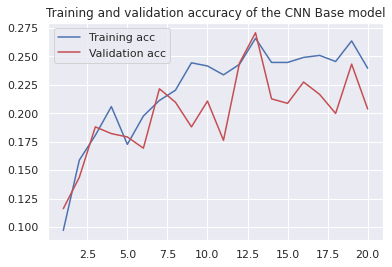

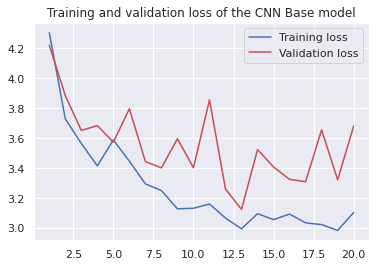

In [ ]:
#Plotting learning evolution
sns.set(style="darkgrid")
acc = hist_baseCNN.history['acc']
val_acc = hist_baseCNN.history['val_acc']
loss = hist_baseCNN.history['loss']
val_loss = hist_baseCNN.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy of the CNN Base model')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss of the CNN Base model')
plt.legend()

In [ ]:
hist_baseCNN.model.evaluate_generator(generator=train_generator, steps=train_generator.n//train_generator.batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1273: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[2.831610990300154, 0.31884766]

In [ ]:
train_generator = train_dataGen.flow_from_directory(directory = os.path.join(data_path, "train"), target_size=(227,227), batch_size=8, color_mode='rgb',class_mode="categorical", shuffle=False)

Found 6149 images belonging to 102 classes.


In [ ]:
#Evaluating model accuracy on training data
STEP_SIZE_TEST=train_generator.n//train_generator.batch_size+1
train_generator.reset()
predictTrain=hist_baseCNN.model.predict_generator(train_generator, steps=STEP_SIZE_TEST,verbose=1)
predTrain = np.argmax(predictTrain, axis=1)

print(classification_report(train_generator.classes, predTrain))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1301: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.63      0.60      0.62        40
           2       0.46      0.09      0.15        67
           3       0.30      0.18      0.23        38
           4       0.47      0.32      0.38        28
           5       0.16      0.69      0.26        67
           6       0.42      0.17      0.24        29
           7       0.36      0.18      0.24        28
           8       0.45      0.31      0.37        29
           9       0.16      0.14      0.15        21
          10       0.45      0.26      0.33        65
          11       0.60      0.05      0.09        62
          12       0.13      0.21      0.16        29
          13       0.14      0.47      0.21        36
          14       0.00      0.00      0.00        20
          15       0.00      0.00      0.00        20
          16       0.00      0.00      0.00        39
          17       0.20    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
hist_baseCNN.model.evaluate_generator(generator=validation_generator, steps=1020//16)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1273: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[3.5666355462301347, 0.22222222]

In [ ]:
validation_generator = train_dataGen.flow_from_directory(directory = os.path.join(data_path, "valid"), target_size=(227,227), batch_size=8, color_mode='rgb',class_mode="categorical", shuffle=False)

Found 1020 images belonging to 102 classes.


In [ ]:
#Evaluating model accuracy on validation data
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size+1
validation_generator.reset()
predictValidation=hist_baseCNN.model.predict_generator(validation_generator, steps=STEP_SIZE_TEST,verbose=1)
predvalid = np.argmax(predictValidation, axis=1)

print(classification_report(validation_generator.classes, predvalid))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1301: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      0.40      0.44        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.67      0.20      0.31        10
           5       0.10      0.60      0.18        10
           6       0.67      0.20      0.31        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.50      0.20      0.29        10
          10       0.43      0.30      0.35        10
          11       0.00      0.00      0.00        10
          12       0.11      0.10      0.11        10
          13       0.07      0.20      0.11        10
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        10
          17       0.12    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
hist_baseCNN.model.evaluate_generator(generator=test_generator, steps=1020//16)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1273: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[3.620853484623016, 0.22222222]

In [ ]:
test_generator = train_dataGen.flow_from_directory(directory = os.path.join(data_path, "test"), target_size=(227,227), batch_size=16, color_mode='rgb',class_mode="categorical",shuffle=False)

Found 1020 images belonging to 102 classes.


In [ ]:
#Evaluating model accuracy on test data
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size+1
test_generator.reset()
predictTest=hist_baseCNN.model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose=1)
predTest = np.argmax(predictTest, axis=1)

print(classification_report(test_generator.classes, predTest))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1301: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.75      0.60      0.67        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.50      0.20      0.29        10
           5       0.16      0.70      0.26        10
           6       0.50      0.10      0.17        10
           7       0.50      0.20      0.29        10
           8       0.60      0.30      0.40        10
           9       0.33      0.10      0.15        10
          10       0.17      0.10      0.12        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.07      0.20      0.10        10
          14       0.00      0.00      0.00        10
          15       1.00      0.10      0.18        10
          16       0.00      0.00      0.00        10
          17       0.17    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results show that the model is overfitting with a poor predictive power. Despite that, we should not be surprised since it's the first shot and we still haven't used many improvements techniques :  
* Deeper Neural Network 
* Transfert Learning : Feature Extraction  & Fine Tuning
* Drop-Out Regularization  

## 3 - Transfert Learning & Feature Extraction   


### 3.2 Transfert Learning   





### Feature extraction   



In [ ]:
convBase = DenseNet121(include_top=False, weights="imagenet", input_shape=(227,227,3))

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
convBase.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 233, 233, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 114, 114, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 114, 114, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
#Basic Features Extraction function
datagen = ImageDataGenerator(rescale=1./255,  preprocessing_function=preprocess_input)
def extractFeatures(directory = 'train' , sample_size = 100, batch_size  = 20):
    features = np.zeros(shape=(sample_size, 7, 7, 1024))
    labels = np.zeros(shape = (sample_size,102))
    generator = datagen.flow_from_directory(directory = os.path.join(data_path, directory), target_size = (227,227), batch_size = batch_size, color_mode = 'rgb',class_mode = 'categorical')
    i = 0
    for imgs, lbls in generator:
        features[i*(batch_size):(i+1)*(batch_size),] = convBase.predict(imgs)
        labels[i*(batch_size):(i+1)*(batch_size),] = lbls
        if i%50==0:
            per = 100*(i+1)*batch_size/generator.n
            print("features & labels extracted at : "+str(np.round(per, decimals=2))+"%")
        i = i+1 #Next batch
        if (i+1)*batch_size > sample_size:
            break
    return features, labels
    

In [ ]:
train_features, train_labels = extractFeatures(directory='train', sample_size=train_generator.n, batch_size= 20)

Found 6149 images belonging to 102 classes.
features & labels extracted at : 0.33%
features & labels extracted at : 16.59%
features & labels extracted at : 32.85%
features & labels extracted at : 49.11%
features & labels extracted at : 65.38%
features & labels extracted at : 81.64%
features & labels extracted at : 97.9%


In [ ]:
valid_features, valid_labels = extractFeatures(directory='valid', sample_size=validation_generator.n, batch_size= 16)

Found 1020 images belonging to 102 classes.
features & labels extracted at : 1.57%
features & labels extracted at : 80.0%


In [ ]:
test_features, test_labels = extractFeatures(directory='test', sample_size=test_generator.n, batch_size= 16)

Found 1020 images belonging to 102 classes.
features & labels extracted at : 1.57%
features & labels extracted at : 80.0%


In [ ]:
#salvo le features estratte
np.save("/content/drive/MyDrive/train_features.npy", train_features)
np.save("/content/drive/MyDrive/train_labels.npy", train_labels)
np.save("/content/drive/MyDrive/test_features.npy", test_features)
np.save("/content/drive/MyDrive/test_labels.npy", test_labels)
np.save("/content/drive/MyDrive/valid_features.npy", valid_features)
np.save("/content/drive/MyDrive/valid_labels.npy", valid_labels)


In [ ]:
#per il load dei file
train_features = np.load("/content/drive/MyDrive/train_features.npy")
train_labels = np.load('/content/drive/MyDrive/train_labels.npy')
test_features = np.load('/content/drive/MyDrive/test_features.npy')
test_labels = np.load('/content/drive/MyDrive/test_labels.npy')

In [ ]:
#Flattening the extracted features for direct use in the classifier
train_features = np.reshape(train_features, (train_features.shape[0], np.product(train_features.shape[1:])))
valid_features = np.reshape(valid_features, (valid_features.shape[0], np.product(valid_features.shape[1:])))
test_features = np.reshape(test_features, (test_features.shape[0], np.product(test_features.shape[1:])))

In [ ]:

def DenseNet121_FC(load_weights = False, conv_base = convBase, dropout=0.3, out_labels=102, initial_weights = "Dense_Weights_Flower102_5.h5"):
    In_Shape = convBase.layers[-1].output_shape
    In_Shape = (np.product(In_Shape[1:]), )   #After being Flattened
    Dense_model = models.Sequential()
    Dense_model.add(Dense(1024, activation = 'tanh', input_shape = In_Shape))
    Dense_model.add(Dropout(dropout))
    Dense_model.add(Dense(512, activation = 'tanh', input_shape = In_Shape))
    Dense_model.add(Dropout(dropout))
    Dense_model.add(Dense(out_labels, activation = 'softmax'))
    if load_weights:
        Dense_model.load_weights(initial_weights)
    return(Dense_model)

In [ ]:
DenseNet_fc = DenseNet121_FC(load_weights=False, conv_base = convBase, dropout=0.3, out_labels=102, initial_weights = "Dense_Weights_Flower102_5.h5")

In [ ]:
DenseNet_fc.compile(optimizer = keras.optimizers.Adam(lr = 0.0001), metrics = ['acc'], loss= "categorical_crossentropy")

In [ ]:
DenseNet_fc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              51381248  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 102)               52326     
Total params: 51,958,374
Trainable params: 51,958,374
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Dense_fc = DenseNet_fc.fit(train_features,train_labels, epochs = 20, batch_size= 16, validation_data = (valid_features,valid_labels ) )

Train on 6149 samples, validate on 1020 samples
Epoch 1/20
6128/6149 [============================>.] - ETA: 0s - loss: 3.6414 - acc: 0.2268

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


6149/6149 [==============================] - 11s 2ms/sample - loss: 3.6379 - acc: 0.2272 - val_loss: 3.0144 - val_acc: 0.2951
Epoch 2/20
6149/6149 [==============================] - 10s 2ms/sample - loss: 2.2089 - acc: 0.5108 - val_loss: 2.0454 - val_acc: 0.5216
Epoch 3/20
6149/6149 [==============================] - 10s 2ms/sample - loss: 1.4522 - acc: 0.6863 - val_loss: 1.4704 - val_acc: 0.6686
Epoch 4/20
6149/6149 [==============================] - 11s 2ms/sample - loss: 0.9910 - acc: 0.8094 - val_loss: 1.1394 - val_acc: 0.7225
Epoch 5/20
6149/6149 [==============================] - 10s 2ms/sample - loss: 0.6881 - acc: 0.8787 - val_loss: 0.9416 - val_acc: 0.7598
Epoch 6/20
6149/6149 [==============================] - 10s 2ms/sample - loss: 0.4929 - acc: 0.9242 - val_loss: 0.7763 - val_acc: 0.8196
Epoch 7/20
6149/6149 [==============================] - 10s 2ms/sample - loss: 0.3706 - acc: 0.9475 - val_loss: 0.7372 - val_acc: 0.8216
Epoch 8/20
6149/6149 [==============================

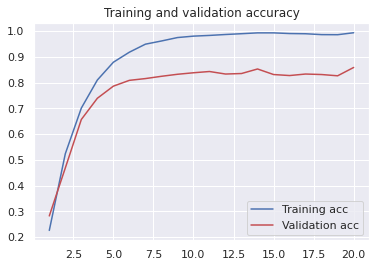

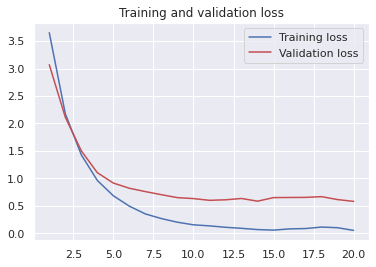

In [ ]:
#Plotting learning evolution
acc = hist_Dense_fc.history['acc']
val_acc = hist_Dense_fc.history['val_acc']
loss = hist_Dense_fc.history['loss']
val_loss = hist_Dense_fc.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

###Peformance Train

In [ ]:
#Otherwise
DenseNet_fc.evaluate(x =train_features , y = train_labels)

[0.01265775946063285, 0.99756056]

In [ ]:
#Evaluating model accuracy on Test data
predTrain = DenseNet_fc.predict(train_features)
predTrain = np.argmax(predTrain, axis=1)
trueTrain = np.argmax(train_labels, axis=1)
TrainAccuracy = np.sum(trueTrain==predTrain)/len(trueTrain)
print("Train accuracy = %f"%TrainAccuracy)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Train accuracy = 0.998048


In [ ]:
train_labels = np.argmax(train_labels, axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(train_labels, predTrain))

              precision    recall  f1-score   support

           0       1.00      0.69      0.82        29
           1       1.00      1.00      1.00        39
           2       1.00      1.00      1.00        67
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        29
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00        29
           9       1.00      1.00      1.00        21
          10       0.98      1.00      0.99        65
          11       1.00      1.00      1.00        62
          12       1.00      1.00      1.00        29
          13       1.00      1.00      1.00        36
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        39
          17       1.00    

###Performance Validation

In [ ]:
#Otherwise
DenseNet_fc.evaluate(x =valid_features , y = valid_labels)

[0.6661192342931149, 0.8352941]

In [ ]:
#Evaluating model accuracy on Test data
predValid = DenseNet_fc.predict(valid_features)
predValid = np.argmax(predValid, axis=1)
trueValid = np.argmax(valid_labels, axis=1)
ValidAccuracy = np.sum(trueValid==predValid)/len(trueValid)
print("Validation accuracy = %f"%ValidAccuracy)

Validation accuracy = 0.858824


In [ ]:
valid_labels = np.argmax(valid_labels, axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_labels, predValid))

              precision    recall  f1-score   support

           0       1.00      0.32      0.48        22
           1       1.00      1.00      1.00         9
           2       1.00      0.90      0.95        10
           3       0.75      0.33      0.46         9
           4       0.91      1.00      0.95        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       0.89      0.80      0.84        10
           8       0.91      1.00      0.95        10
           9       0.89      0.89      0.89         9
          10       0.89      0.89      0.89         9
          11       0.83      0.56      0.67         9
          12       0.83      1.00      0.91        10
          13       1.00      0.70      0.82        10
          14       1.00      0.30      0.46        10
          15       0.88      0.70      0.78        10
          16       1.00      0.90      0.95        10
          17       1.00    

###Test Perfomance

In [ ]:
#Otherwise
DenseNet_fc.evaluate(x =test_features , y = test_labels)

[0.6763138820143307, 0.8372549]

In [ ]:
#Evaluating model accuracy on Test data
predTest = DenseNet_fc.predict(test_features)
predTest = np.argmax(predTest, axis=1)
trueTest = np.argmax(test_labels, axis=1)
TestAccuracy = np.sum(trueTest==predTest)/len(trueTest)
print("Test accuracy = %f"%TestAccuracy)

Test accuracy = 0.867647


In [ ]:
test_labels = np.argmax(test_labels, axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predTest))

              precision    recall  f1-score   support

           0       1.00      0.41      0.58        22
           1       1.00      1.00      1.00         9
           2       0.88      0.78      0.82         9
           3       1.00      0.50      0.67        10
           4       1.00      1.00      1.00        10
           5       0.75      0.90      0.82        10
           6       1.00      0.90      0.95        10
           7       1.00      1.00      1.00        10
           8       1.00      0.90      0.95        10
           9       1.00      0.60      0.75        10
          10       1.00      1.00      1.00        10
          11       1.00      0.70      0.82        10
          12       1.00      0.90      0.95        10
          13       0.80      0.89      0.84         9
          14       0.80      0.40      0.53        10
          15       1.00      0.89      0.94         9
          16       0.82      0.90      0.86        10
          17       1.00    

In [ ]:
#Saving Model/Weights for future use (eventually) 
hist_Dense_fc.model.save("/content/drive/MyDrive/DenseNet_Flower102_5.h5")
hist_Dense_fc.model.save_weights("/content/drive/MyDrive/DenseNet_Weights_Flower102_5.h5")

### Dense121 + Linear SVC

In [ ]:
train_labels = np.argmax(train_labels, axis=1)

In [ ]:
from sklearn.svm import LinearSVC, SVC

svm = LinearSVC(verbose=2, max_iter=1000, C=0.1)
svm.fit(train_features, train_labels) 

[LibLinear]

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=2)

In [ ]:
#Train
from sklearn.metrics import classification_report
predictions_train = svm.predict(train_features)
print(classification_report(train_labels, predictions_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        39
           2       1.00      1.00      1.00        67
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        29
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00        29
           9       1.00      1.00      1.00        21
          10       1.00      1.00      1.00        65
          11       1.00      1.00      1.00        62
          12       1.00      1.00      1.00        29
          13       1.00      1.00      1.00        36
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        39
          17       1.00    

In [ ]:
#Valid
from sklearn.metrics import classification_report
predictions_valid = svm.predict(valid_features)
print(classification_report(valid_labels, predictions_valid))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       1.00      1.00      1.00         9
           2       0.80      0.80      0.80        10
           3       0.62      0.56      0.59         9
           4       0.91      1.00      0.95        10
           5       0.83      1.00      0.91        10
           6       1.00      1.00      1.00        10
           7       0.89      0.80      0.84        10
           8       0.91      1.00      0.95        10
           9       0.80      0.89      0.84         9
          10       1.00      0.89      0.94         9
          11       0.78      0.78      0.78         9
          12       0.62      0.80      0.70        10
          13       1.00      0.70      0.82        10
          14       0.67      0.40      0.50        10
          15       0.90      0.90      0.90        10
          16       0.91      1.00      0.95        10
          17       0.69    

In [ ]:
#Test
from sklearn.metrics import classification_report
predictions_test = svm.predict(test_features)
print(classification_report(test_labels, predictions_test))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       1.00      1.00      1.00         9
           2       0.89      0.89      0.89         9
           3       0.89      0.80      0.84        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       0.91      1.00      0.95        10
           8       0.90      0.90      0.90        10
           9       0.88      0.70      0.78        10
          10       1.00      1.00      1.00        10
          11       0.90      0.90      0.90        10
          12       1.00      0.90      0.95        10
          13       1.00      0.78      0.88         9
          14       0.00      0.00      0.00        10
          15       1.00      1.00      1.00         9
          16       1.00      1.00      1.00        10
          17       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Prediction

In [ ]:
#Predict the label of your own flower image
img_path = '/content/drive/MyDrive/Flowers102/test/48/image_06205.jpg'
img = image.load_img(img_path, target_size=(227, 227, 3))
t = np.expand_dims(img, axis=0)
print('Input image shape:', t.shape)
my_image = imageio.imread(img_path)
plt.imshow(img)

In [ ]:
#Prediction
extr_feature = convBase.predict(t)
extr_feature = extr_feature.reshape((extr_feature.shape[0], np.product(extr_feature.shape[1:])))
sample_pred = svm.predict(extr_feature)
sample_pred = to_categorical(sample_pred)
#print(to_categorical(sample_pred))
print('image label : '+ str(np.argmax(sample_pred))) 
print('flower name : ' +str(getName(sample_pred)))

## 4 - FINE TUNING
In this section, we will attempt to improve accuracy by unfreezing a part of the pretrained model's base (in our case, the last Convolutional Layers of the DensNet convolutional base model for example) in order to adjust the more abstract representations to fit better the problem at hand (flower image recognition in our case).   
To do so, we need to start from an already pretrained base model on a large and general data set plus a pretrained on-top part on the small data at hand (the fully connected classifier in our case).  
 


### preprocessing data

In [ ]:
train_data_Aug_Gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=25, zoom_range=0.2, 
                                        shear_range=0.15, fill_mode='nearest', preprocessing_function = preprocess_input)
test_data_Gen = ImageDataGenerator(rescale=1./255, preprocessing_function = preprocess_input)

In [ ]:
train_data_Aug_Genenerator = train_data_Aug_Gen.flow_from_directory(directory = os.path.join(data_path, 'train'), target_size = (227,227), batch_size = 8, color_mode = 'rgb',class_mode = 'categorical')

Found 6149 images belonging to 102 classes.


In [ ]:
test_data_Generator = test_data_Gen.flow_from_directory(directory = os.path.join(data_path, 'test'), target_size = (227,227), batch_size = 16, color_mode = 'rgb',class_mode = 'categorical')

Found 1020 images belonging to 102 classes.


In [ ]:
valid_data_Generator = test_data_Gen.flow_from_directory(directory = os.path.join(data_path, 'valid'), target_size = (227,227), batch_size = 16, color_mode = 'rgb',class_mode = 'categorical')

Found 1020 images belonging to 102 classes.


### fine tuning

In [ ]:
convBase.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 233, 233, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 114, 114, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 114, 114, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
convBase.trainable = True
for layer in convBase.layers:
    if 'conv5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
In_Shape = convBase.layers[-1].output_shape
In_Shape = (np.product(In_Shape[1:]), )

In [ ]:
last = convBase.layers[-2].output
x = Flatten()(last)
x = Dense(1024, activation="tanh", input_shape=In_Shape)(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="tanh",input_shape=In_Shape)(x)
x = Dropout(0.3)(x)
x = Dense(102, activation="softmax")(x)
DenseNet_Fine_Tuning = Model(convBase.input, x)

In [ ]:
DenseNet_Fine_Tuning.compile(optimizer = keras.optimizers.Adam(lr = 0.0001), metrics = ['acc'], loss= "categorical_crossentropy")
DenseNet_Fine_Tuning.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 233, 233, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 114, 114, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 114, 114, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
hist_Densenet_tuned = DenseNet_Fine_Tuning.fit_generator(train_data_Aug_Genenerator, steps_per_epoch=m_train//batch_tr+100, epochs=20, validation_data=valid_data_Generator, validation_steps=1020//8)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/20
868/868 [==============================] - ETA: 0s - batch: 433.5000 - size: 7.9965 - loss: 1.6926 - acc: 0.6440

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


868/868 [==============================] - 152s 168ms/step - batch: 433.5000 - size: 7.9965 - loss: 1.6926 - acc: 0.6440 - val_loss: 1.5225 - val_acc: 0.6257
Epoch 2/20
868/868 [==============================] - 143s 165ms/step - batch: 433.5000 - size: 7.9965 - loss: 0.6719 - acc: 0.8705 - val_loss: 1.2182 - val_acc: 0.7002
Epoch 3/20
868/868 [==============================] - 143s 165ms/step - batch: 433.5000 - size: 7.9931 - loss: 0.4562 - acc: 0.9118 - val_loss: 1.2258 - val_acc: 0.6923
Epoch 4/20
868/868 [==============================] - 143s 164ms/step - batch: 433.5000 - size: 7.9965 - loss: 0.3430 - acc: 0.9362 - val_loss: 0.9606 - val_acc: 0.7599
Epoch 5/20
868/868 [==============================] - 142s 163ms/step - batch: 433.5000 - size: 8.0000 - loss: 0.2757 - acc: 0.9477 - val_loss: 0.9624 - val_acc: 0.7505
Epoch 6/20
868/868 [==============================] - 142s 163ms/step - batch: 433.5000 - size: 7.9931 - loss: 0.2626 - acc: 0.9483 - val_loss: 0.9378 - val_acc: 0.76

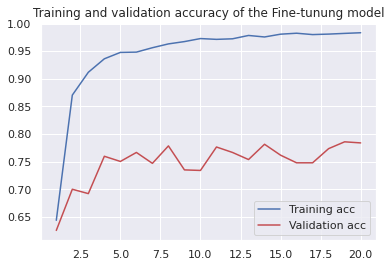

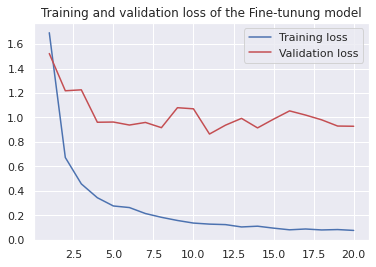

In [ ]:
#Plotting learning evolution
sns.set(style="darkgrid")
acc = hist_Densenet_tuned.history['acc']
val_acc = hist_Densenet_tuned.history['val_acc']
loss = hist_Densenet_tuned.history['loss']
val_loss = hist_Densenet_tuned.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy of the Fine-tunung model')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss of the Fine-tunung model')
plt.legend()

### Performance Train

In [ ]:
train_data_Aug_Genenerator = train_data_Aug_Gen.flow_from_directory(directory = os.path.join(data_path, 'train'), target_size = (227,227), batch_size = 8, color_mode = 'rgb',class_mode = 'categorical', shuffle=False)
hist_Densenet_tuned.model.evaluate_generator(train_data_Aug_Genenerator, steps=train_data_Aug_Genenerator.n//8)

Found 6149 images belonging to 102 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1273: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.37473703639235606, 0.8933919]

In [ ]:
#Evaluating model accuracy on training data
STEP_SIZE_TEST=train_data_Aug_Genenerator.n//train_data_Aug_Genenerator.batch_size+1
train_data_Aug_Genenerator.reset()
predictTrain=hist_Densenet_tuned.model.predict_generator(train_data_Aug_Genenerator, steps=STEP_SIZE_TEST,verbose=1)
predTrain = np.argmax(predictTrain, axis=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1301: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
print(classification_report(train_data_Aug_Genenerator.classes, predTrain))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       1.00      0.88      0.93        40
           2       0.66      0.96      0.78        67
           3       1.00      0.29      0.45        38
           4       1.00      0.96      0.98        28
           5       0.97      0.94      0.95        67
           6       1.00      0.90      0.95        29
           7       1.00      0.93      0.96        28
           8       0.96      0.86      0.91        29
           9       0.80      0.95      0.87        21
          10       1.00      0.88      0.93        65
          11       1.00      0.71      0.83        62
          12       0.96      0.93      0.95        29
          13       1.00      0.69      0.82        36
          14       0.53      0.90      0.67        20
          15       0.74      1.00      0.85        20
          16       0.95      0.95      0.95        39
          17       1.00    

### Performance Validation

In [ ]:
valid_data_Generator = test_data_Gen.flow_from_directory(directory = os.path.join(data_path, 'valid'), target_size = (227,227), batch_size = 16, color_mode = 'rgb',class_mode = 'categorical',shuffle=False)
DenseNet_Fine_Tuning.evaluate_generator(valid_data_Generator, steps=1020//16)

Found 1020 images belonging to 102 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1273: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.9203196609363197, 0.7867063]

In [ ]:
#Evaluating model accuracy on validation data
STEP_SIZE_TEST=valid_data_Generator.n//valid_data_Generator.batch_size+1
valid_data_Generator.reset()
predictValid=hist_Densenet_tuned.model.predict_generator(valid_data_Generator, steps=STEP_SIZE_TEST,verbose=1)
predVal = np.argmax(predictValid, axis=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1301: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
print(classification_report(valid_data_Generator.classes, predVal))

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       1.00      1.00      1.00        10
           2       0.73      0.80      0.76        10
           3       1.00      0.10      0.18        10
           4       0.82      0.90      0.86        10
           5       0.91      1.00      0.95        10
           6       1.00      0.90      0.95        10
           7       0.89      0.80      0.84        10
           8       0.90      0.90      0.90        10
           9       0.83      1.00      0.91        10
          10       1.00      0.70      0.82        10
          11       1.00      0.80      0.89        10
          12       0.82      0.90      0.86        10
          13       1.00      0.30      0.46        10
          14       0.60      0.60      0.60        10
          15       0.80      0.80      0.80        10
          16       1.00      0.80      0.89        10
          17       1.00    

### Test Performance

In [ ]:
test_data_Generator = test_data_Gen.flow_from_directory(directory = os.path.join(data_path, 'test'), target_size = (227,227), batch_size = 16, color_mode = 'rgb',class_mode = 'categorical',shuffle=False)
DenseNet_Fine_Tuning.evaluate_generator(test_data_Generator, steps=1020//16)

Found 1020 images belonging to 102 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1273: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.8972279961620059, 0.80654764]

In [ ]:
#Evaluating model accuracy on test data
STEP_SIZE_TEST=test_data_Generator.n//test_data_Generator.batch_size+1
test_data_Generator.reset()
predictTest=hist_Densenet_tuned.model.predict_generator(test_data_Generator, steps=STEP_SIZE_TEST,verbose=1)
predTest = np.argmax(predictTest, axis=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1301: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
print(classification_report(test_data_Generator.classes, predTest))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       1.00      0.80      0.89        10
           2       0.67      1.00      0.80        10
           3       1.00      0.20      0.33        10
           4       0.82      0.90      0.86        10
           5       1.00      0.90      0.95        10
           6       0.90      0.90      0.90        10
           7       1.00      1.00      1.00        10
           8       1.00      0.90      0.95        10
           9       0.73      0.80      0.76        10
          10       1.00      0.80      0.89        10
          11       1.00      0.70      0.82        10
          12       0.89      0.80      0.84        10
          13       1.00      0.70      0.82        10
          14       0.67      0.40      0.50        10
          15       0.82      0.90      0.86        10
          16       0.75      0.90      0.82        10
          17       0.91    

In [ ]:
hist_Densenet_tuned.model.save_weights("/content/drive/MyDrive/DenseNet_Fine_Tuned_Weights.h5")
hist_Densenet_tuned.model.save("/content/drive/MyDrive/DenseNet_Fine_Tuned_model.h5")